# Ascaso-Extended Models Calibration


---
**License**

 Ascaso_Extended_Calibration

 Tue Aug 24 10:30:00 2021\
 Copyright  2021\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_Calibration\
 Copyright (C) 2021 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Ascaso_Extended_Calibration")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

#Calibration functions
from AEC_data_binning import BinnedData as BData
from AEC_calibration import RichnessMassRelationCalibration as RMRC
from AEC_Plot import cplot
from AEC_corrected_moments import expected_value, standard_deviation

#Useful packages
import numpy as np
from astropy.io import fits
from astropy.table import Table

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


## Data

### NumCosmo's Matching By Proximity

Data from `cosmoDC2_v1.1.4_image` and `cosmoDC2_v1.1.4_redmapper_v0.8.1` catalogs matched by proximity . See [matching_by_proximity.ipynb](https://github.com/NumCosmo/NumCosmo/blob/ascaso_interface/notebooks/richness_proxy/CatalogsMatching/matching_by_proximity.ipynb)

In [2]:
# DC2_rM_mdata = Table.read('../CatalogsMatching/match_proximity.fits')
# DC2_rM_mdata.rename_column('R', 'richness')
# DC2_rM_mdata.rename_column('R_err', 'richness_err')
# DC2_rM_mdata.rename_column('z', 'redshift')

### Matching by ID 

Data from `cosmoDC2_v1.1.4_image` and `cosmoDC2_v1.1.4_redmapper_v0.8.1` catalogs matched by ID . See [matching_by_ID.ipynb](https://github.com/NumCosmo/NumCosmo/blob/ascaso_interface/notebooks/richness_proxy/CatalogsMatching/matching_by_ID.ipynb)

In [3]:
# DC2_rM_mdata = Table.read('CatalogsMatching/match_ID.fits')
# DC2_rM_mdata.rename_column('halo_mass', 'mass')

### Clevar Matching

In [4]:
import clevar
from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
from clevar.match import output_matched_catalog
from clevar.match_metrics.scaling import ClCatalogFuncs as s_cf

# CLEVAR
min_richness = 5
min_halo_mass = 1e13 #Msun

# Halos/Clusters
#CosmoDC2 + RedMaPPer: 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
RM_cat = ClCatalog.read('/global/homes/c/cinlima/Data/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})

#CosmoDC2: 'cosmoDC2_v1.1.4_image'
halo_cat = ClCatalog.read('/global/homes/c/cinlima/Data/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})

#Members
RM_cat.read_members('/global/homes/c/cinlima/Data/CDC2Data/RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
halo_cat.read_members('/global/homes/c/cinlima/Data/CDC2Data/halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

#Match catalogs
mt = MembershipMatch()

mt.load_matches(RM_cat, halo_cat, out_dir='/global/homes/c/cinlima/Data/CDC2Data/cosmoDC2_RM_match_cross_membership')
RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')

RM_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    45,081
 * multiple (self):  43,213
 * multiple (other): 43,213
 * unique (self):    43,035
 * unique (other):   43,037
 * cross:            43,035

halo_cat
    * ClEvar used in matching: 0.14.1
 * Total objects:    471,457
 * multiple (self):  75,785
 * multiple (other): 75,785
 * unique (self):    43,037
 * unique (other):   43,035
 * cross:            43,035


In [5]:
DC2_rM_mdata = Table([halo_cat_bij['mass_fof'], RM_cat_bij['richness'], RM_cat_bij['richness_err'], RM_cat_bij['z']], names=('mass', 'richness', 'richness_err', 'redshift'))

DC2_rM_mdata['richness'].max()



266.29504

## Fit

The richness-mass distribution is:

$$
    P(\ln(\lambda)|M, z) = \frac{  1  }{   \sqrt{2 \pi} \sigma_{\ln\lambda}    }     \frac{   \exp \left[   - \frac{ (\ln(\lambda) - \left< \ln(\lambda)| M, z \right>)^2  }{ 
 2 \sigma_{\ln \lambda}^2}\right]  }{ \zeta }.
$$

Where $\zeta$ is a factor to normalize the truncated distribution, and $\Phi\left( x \right)$ is the cumulative of a normal distribution: 
$$
    \zeta =  1 - \Phi\left(\frac{x_{cut} - \left< \ln(\lambda)| M, z \right>} {  \sigma_{\ln \lambda}} \right);
$$
$$
     \Phi\left( x \right) = \frac{1}{2} ( 1 + \mbox{erf}\left(  x / \sqrt{2} \right)).
$$

To make the fit we calculate the MLE.

$$
\hat{p_i} = arg \ \underset{ p_i \in \textbf{p}}{min} \left\{  -2 \ln \left(\mathscr{L}(ln\lambda| M, z, \textbf{p}) \right) \right\}.
$$


Where the likelihood is:

$$
\mathscr{L}(ln\lambda| M, z, \textbf{p}) = \prod_{ i = 1 } ^{ n } P(\ln(\lambda_i)|M, z, \textbf{p}).
$$

In [6]:
richness_cut = 5.0
rmc = RMRC(DC2_rM_mdata, richness_cut)

### Linear

Here we do the fitting of linear model parameters. The model is:

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$

$\textbf{p}_{1}$ is the vector with the linear model parameters.


In [7]:
ascaso, fit_ascaso, dmr_asc = rmc.run_fit('ascaso')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1.6094379124341     [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

In [8]:
lnR_mean_ascaso = rmc.get_mean_model(ascaso,  np.log(DC2_rM_mdata["mass"]),  DC2_rM_mdata["redshift"])
lnR_std_ascaso = rmc.get_std_model(ascaso,  np.log(DC2_rM_mdata["mass"]),  DC2_rM_mdata["redshift"])

### Quadratic
Here we do the fitting of quadratic model parameters. The model is:

\begin{equation}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

$\textbf{p}_{2}$ is the vector with the quadratic model parameters.


In [9]:
ext_ln1pz, fit_ext, dmr_ext = rmc.run_fit('ext_ln1pz')

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

In [10]:
lnR_mean_ext_ln1pz = rmc.get_mean_model(ext_ln1pz,  np.log(DC2_rM_mdata["mass"]),  DC2_rM_mdata["redshift"])
lnR_std_ext_ln1pz = rmc.get_std_model(ext_ln1pz,  np.log(DC2_rM_mdata["mass"]),  DC2_rM_mdata["redshift"])

## Moments

Mean:
$$
    \mbox{E} [ \ln\lambda | M,z ] = \left< \ln \lambda | M, z \right> +  \frac{\sigma_{\ln \lambda} \exp[\frac{x_{cut} - \left< \ln(\lambda)| M, z \right>  }{  \sigma_{\ln \lambda}}]}{\sqrt{2 \pi} \zeta }
$$

Standard deviation:
$$
    \sigma [\ln\lambda | M,z ] =  \sigma_{\ln \lambda} \sqrt{ 1 + \left( \frac{x_{cut} - \left< \ln(\lambda)| M, z \right>  }{  \sigma_{\ln \lambda}} \right)\frac{\exp[\frac{x_{cut} - \left< \ln(\lambda)| M, z \right>  }{  \sigma_{\ln \lambda}}]}{\sqrt{2 \pi}  \zeta } - \left( \frac{\exp[\frac{x_{cut} - \left< \ln(\lambda)| M, z \right>  }{  \sigma_{\ln \lambda}}]}{\sqrt{2 \pi}  \zeta }\right)^{2}}
$$

In [11]:
# lnR_mean_ext_ln1pz_corrected = expected_value(lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, richness_cut)
# lnR_std_ext_ln1pz_corrected = standard_deviation(lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, richness_cut)

# lnR_mean_ascaso_corrected = expected_value(lnR_mean_ascaso, lnR_std_ascaso, richness_cut)
# lnR_std_ascaso_corrected = standard_deviation(lnR_mean_ascaso, lnR_std_ascaso, richness_cut)

## Model Plots

### Binned data

We reconstruct the mean calculating the average of richness $\lambda$ weighted by the richness error $\lambda_{\mbox{Err}}$ in each bin.
$$
\hat{\mu} =  \frac{1}{\sum_j \lambda_{\mbox{Err}_j}} \sum_i \lambda_i \frac{1}{ \lambda_{\mbox{Err}_i}}
$$

For standard deviation we use:
$$
\hat{\sigma} = \sqrt{ \sum_i \frac{ | \ln \lambda_i - \ln \hat{\mu}|}{ N - 1} }
$$


In [12]:
bd = BData(DC2_rM_mdata, 0.05, 0.05)
binned_mean = bd.get_bins_mean()
binned_std = bd.get_bins_std()


DC2_rM_mdata_cut = DC2_rM_mdata[np.logical_and(DC2_rM_mdata['richness'] > 10, DC2_rM_mdata['mass'] > 4e13)]

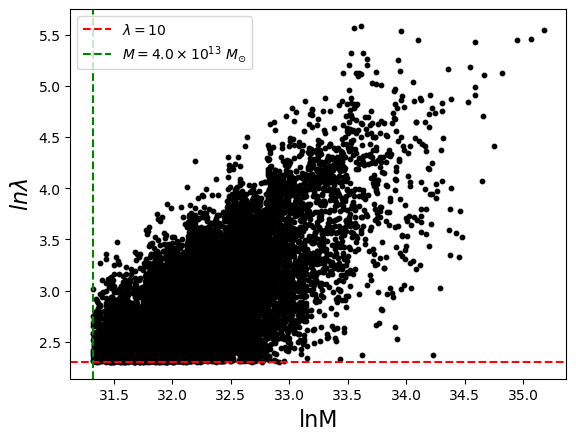

In [13]:
plt.scatter(np.log(DC2_rM_mdata_cut['mass']), np.log(DC2_rM_mdata_cut['richness']), c = 'k', s=10)
# plt.scatter(np.log(DC2_rM_mdata['mass']), lnR_mean_ascaso, c = 'red', s=10)
plt.axline((np.log(4e13), np.log(10)), (35, np.log(10)), c = 'r', ls= '--', label = '$\lambda = 10$')
plt.axline((np.log(4e13), np.log(10)), (np.log(4e13), 5.5), c = 'g', ls= '--', label = '$M = 4.0 \\times 10^{13} \ M_{\\odot}$')

plt.xlabel('lnM', fontsize=16)
plt.ylabel('$ln\lambda$', fontsize=16)
plt.legend()

plt.show()

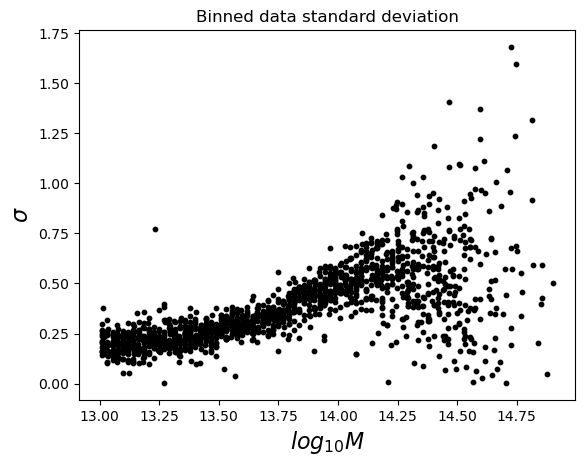

TypeError: Figure.savefig() missing 1 required positional argument: 'fname'

<Figure size 640x480 with 0 Axes>

In [27]:
plt.scatter(np.log10(binned_mean["mass"]), binned_std, c='k', s=10)
plt.xlabel('$log_{10} M$', fontsize=16)
plt.ylabel('$\sigma$', fontsize=16)
# plt.axline((13, np.log10(15)), (15, np.log10(15)), c = 'r', ls= '--', label = '$\lambda = 15$')
# plt.axline((np.log10(0.5e14), np.log10(5)), (np.log10(0.5e14), np.log10(180)), c = 'g', ls= '--', label = '$M = 0.5 \\times 10^{14} \ M_{\\odot}$')
# plt.legend()
plt.title('Binned data standard deviation')

plt.show()

plt.savefig()

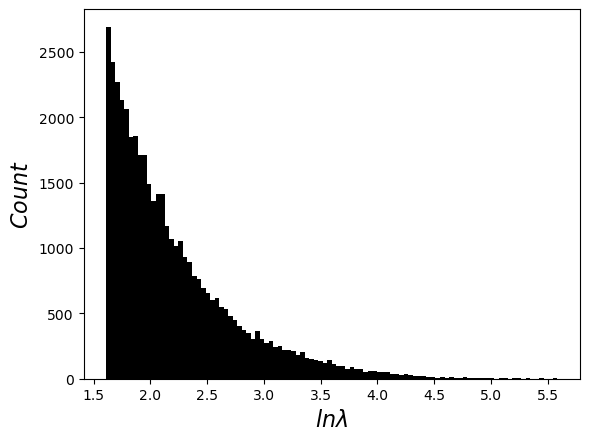

In [19]:
plt.hist(np.log(DC2_rM_mdata['richness']), color = 'k', bins=100)
plt.xlabel('$ln\lambda$', fontsize=16)
plt.ylabel('$Count$', fontsize=16)

plt.show()

### Mean

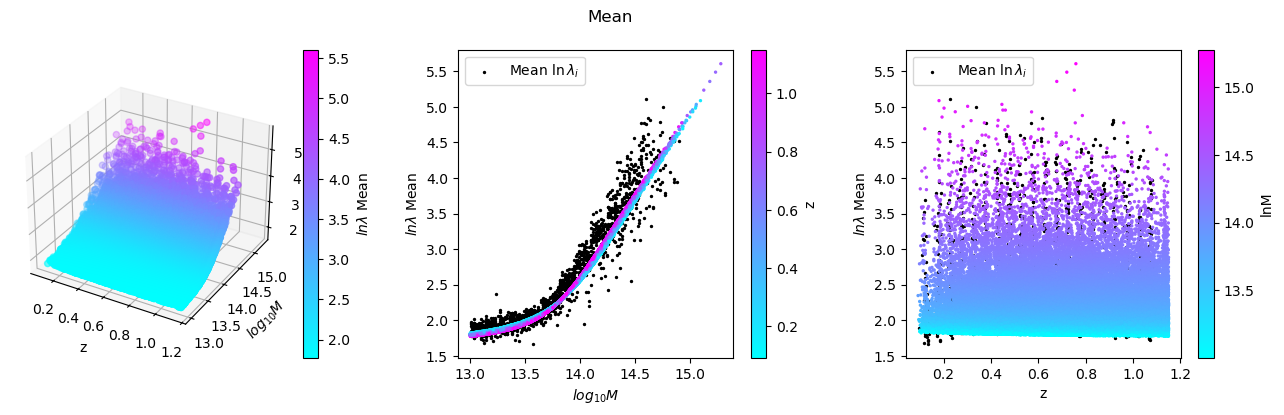

In [20]:
cplot(lnR_mean_ascaso, 'lnR_mean_ascaso', DC2_rM_mdata, binned_mean, binned_std) #Ascaso
# cplot(lnR_mean_ascaso_corrected, 'lnR_mean_ascaso_c', DC2_rM_mdata, binned_mean, binned_std) #Ascaso corrected
# cplot(lnR_mean_ext_ln1pz, 'lnR_mean_ext_ln1pz', DC2_rM_mdata, binned_mean, binned_std) #Extended 
# cplot(lnR_mean_ext_ln1pz_corrected, 'lnR_mean_ext_ln1pz_c', DC2_rM_mdata, binned_mean, binned_std) #Extended corrected
plt.show()

### Standard deviation

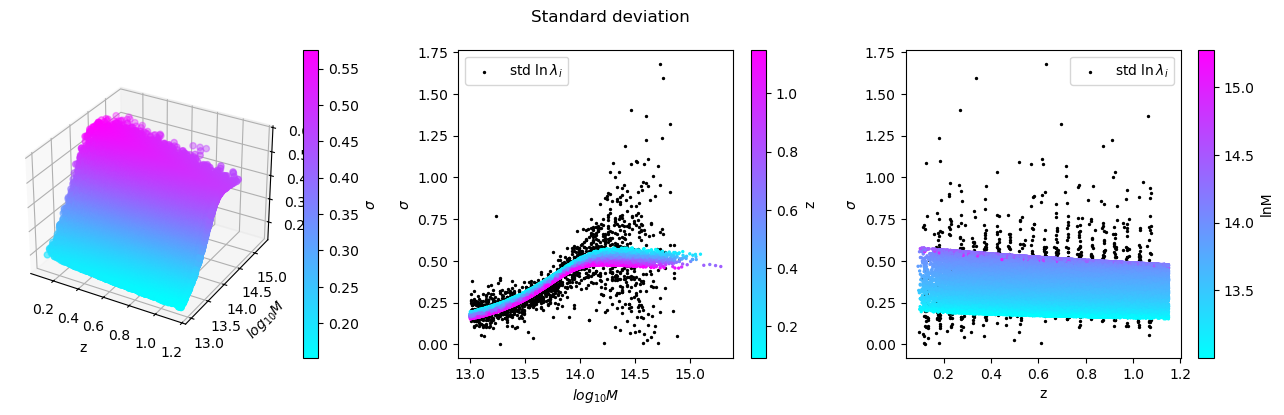

In [21]:
cplot(lnR_std_ascaso, 'lnR_std_ascaso', DC2_rM_mdata, binned_mean, binned_std, option = "std") #Ascaso
# cplot(lnR_std_ascaso_corrected, 'lnR_std_ascaso_c', DC2_rM_mdata, binned_mean, binned_std, option = "std") #Ascaso corrected
# cplot(lnR_std_ext_ln1pz, 'lnR_std_ext_ln1pz', DC2_rM_mdata, binned_mean, binned_std, option = "std") #Extended  
# cplot(lnR_std_ext_ln1pz_corrected, 'lnR_std_ext_ln1pz_c', DC2_rM_mdata, binned_mean, binned_std, option = "std") #Extended corrected
plt.show()